                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.979223   0.065705  0.863158  0.122115
1        Random Forest  0.999507   0.913580  0.778947  0.840909
2              XGBoost  0.999418   0.852273  0.789474  0.819672
                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.979223   0.065705  0.863158  0.122115  0.251843
1        Random Forest  0.999507   0.913580  0.778947  0.840909  0.802603
2              XGBoost  0.999418   0.852273  0.789474  0.819672  0.801282
                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score  \
0  Logistic Regression  0.979223   0.065705  0.863158  0.122115  0.251843   
1        Random Forest  0.999507   0.913580  0.778947  0.840909  0.802603   
2              XGBoost  0.999418   0.852273  0.789474  0.819672  0.801282   

   Precision-Recall AUC  
0                   NaN  
1              0.814689  
2                   NaN  


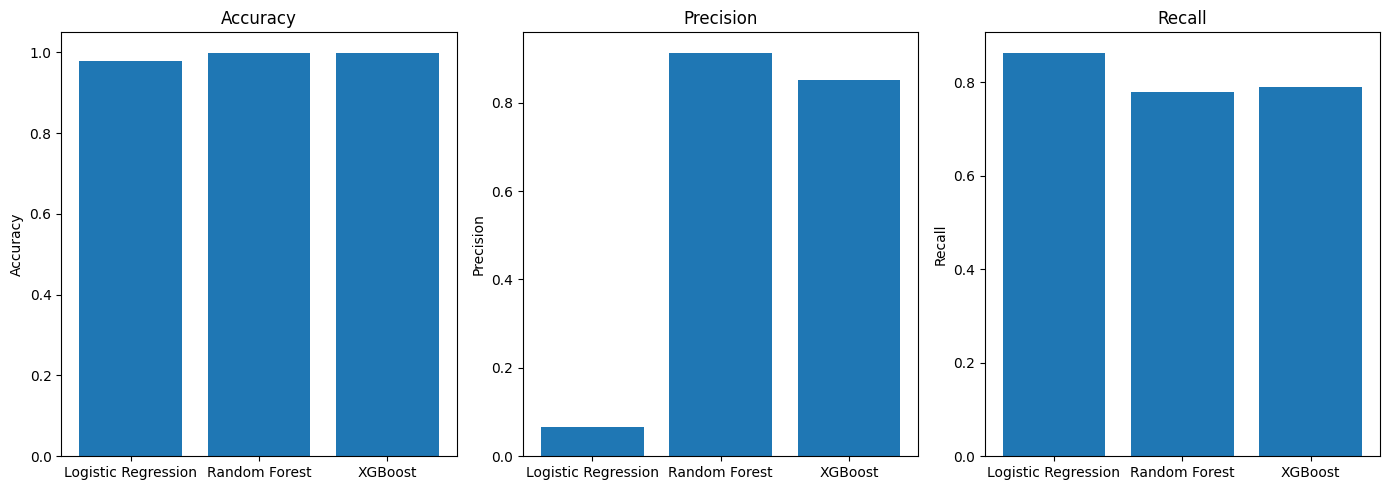

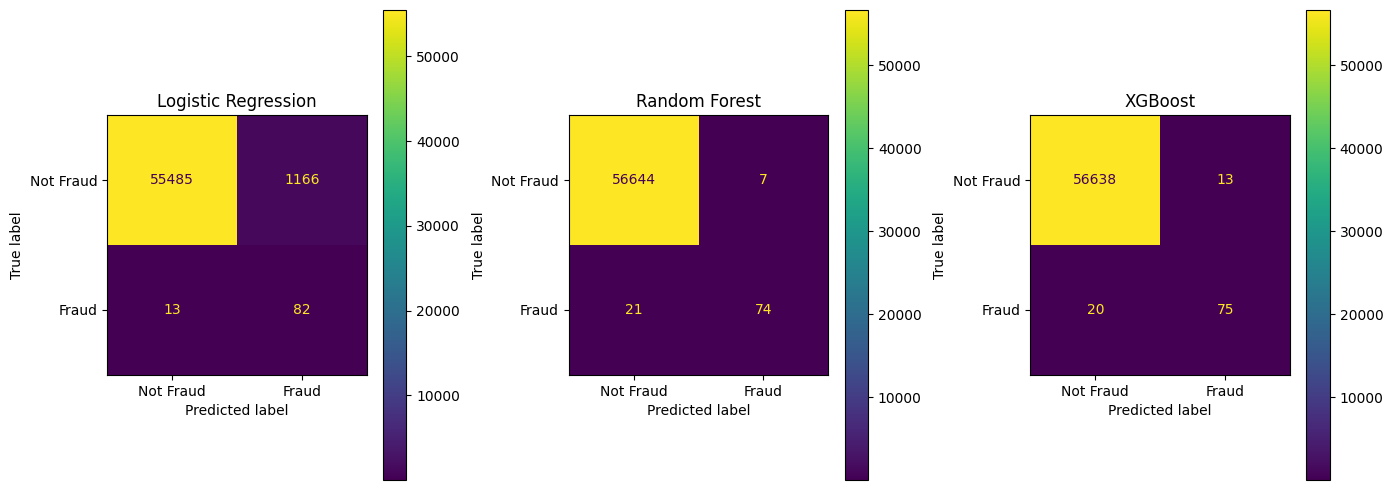

In [1]:
# importing necessary libraries
import pandas as pd
import joblib as jb
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import matplotlib.pyplot as plt
# Load predictions
predictions_df = pd.read_csv('../data/processed/model_predictions.csv')
y_test = predictions_df['y_test'].values
y_pred_logistic = predictions_df['y_pred_logistic'].values
y_pred_rf = predictions_df['y_pred_rf'].values
y_pred_xgb = predictions_df['y_pred_xgb'].values
# Load models and test data
rf_model = jb.load('../models/random_forest.pkl')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()
#Probability scores for fraud class
y_proba=rf_model.predict_proba(X_test)[:, 1] # Assuming the positive class (fraud) is labeled as 1

#Dynamicly calculating metrtics 


metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_logistic),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, y_pred_logistic),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, y_pred_logistic),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_logistic),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ]
})
print(metrics_df)
# Adding F2 score to the metrics dataframe
metrics_df["F2 Score"] = [
    fbeta_score(y_test, y_pred_logistic, beta=2),
    fbeta_score(y_test, y_pred_rf, beta=2),
    fbeta_score(y_test, y_pred_xgb, beta=2)
]
print(metrics_df)
#Adding presicion-recall AUC for random forest model
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba)
auc_rf = auc(recall_rf, precision_rf)
metrics_df["Precision-Recall AUC"] = [None, auc_rf, None] # Only for Random Forest
print(metrics_df)

#Visualization of the metrics, 3 graphs, one for each metric, with the three models on the x-axis and the metric values on the y-axis
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
models = metrics_df["Model"]
accuracy = metrics_df["Accuracy"]
precision = metrics_df["Precision"]
recall = metrics_df["Recall"]
f1_score = metrics_df["F1 Score"]

axs[0].bar(models, accuracy)
axs[0].set_title("Accuracy")
axs[0].set_ylabel("Accuracy")

axs[1].bar(models, precision)
axs[1].set_title("Precision")
axs[1].set_ylabel("Precision")

axs[2].bar(models, recall)
axs[2].set_title("Recall")
axs[2].set_ylabel("Recall")

plt.tight_layout()
plt.show()
#Confusion matrix visualization for each model
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
cm_lr = confusion_matrix(y_test, y_pred_logistic)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Not Fraud", "Fraud"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Not Fraud", "Fraud"])
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Not Fraud", "Fraud"])
disp_lr.plot(ax=axs[0])
disp_rf.plot(ax=axs[1])
disp_xgb.plot(ax=axs[2])
axs[0].set_title("Logistic Regression")
axs[1].set_title("Random Forest")
axs[2].set_title("XGBoost")
plt.tight_layout()
plt.show()

The best one is Random Forest.